# 프로젝트: 인물 사진

## 1. 라이브러리 불러오기 & 경로 설정

In [ ]:
! pip install opencv-python pixellib

In [2]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


In [3]:
# 파일 경로
home_dir = '/content/drive/MyDrive/aiffel_rs_16/Ex02/'

# 이미지 경로
img_path_1 = os.path.join(home_dir, 'proud-me.png')
img_path_2 = os.path.join(home_dir, 'loopy.png')
img_path_3 = os.path.join(home_dir, 'korea.png')
img_path_4 = os.path.join(home_dir, 'cat.jpg')
img_path_5 = os.path.join(home_dir, 'butterfly.png')
img_path_6 = os.path.join(home_dir, 'universe.jpg') # jpg, png 파일 형식 상관 없이 학습 가능

## 2. 함수 정의

In [4]:
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {img_path}")
    return img

In [5]:
def load_model():
    model = deeplabv3_resnet101(pretrained=True)
    model.eval()
    return model

In [6]:
def segment_image(model, img):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
    ])

    input_tensor = transform(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        pred = output.argmax(0).byte().cpu().numpy()

    # 원본 크기로 복원
    pred_resized = cv2.resize(
        pred,
        (img.shape[1], img.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    return pred_resized

In [7]:
def get_person_mask(seg_map, person_class_id=15):
    mask = (seg_map == person_class_id).astype(np.uint8) * 255
    return mask

In [8]:
def overlay_mask(img, mask): # segmentation 오류 강조용
    color_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, color_mask, 0.4, 0)
    return overlay

In [9]:
def visualize_results(img, mask, overlay):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask (Target Class)")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Mask Overlay (Error Visualization)")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
def analyze_multiple_images(image_infos, model):
    for info in image_infos:
        print(f"\n Analyzing: {info['name']}")

        img = load_image(info["path"])
        seg_map = segment_image(model, img)
        mask = get_person_mask(seg_map)
        overlay = overlay_mask(img, mask)

        visualize_results(img, mask, overlay)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


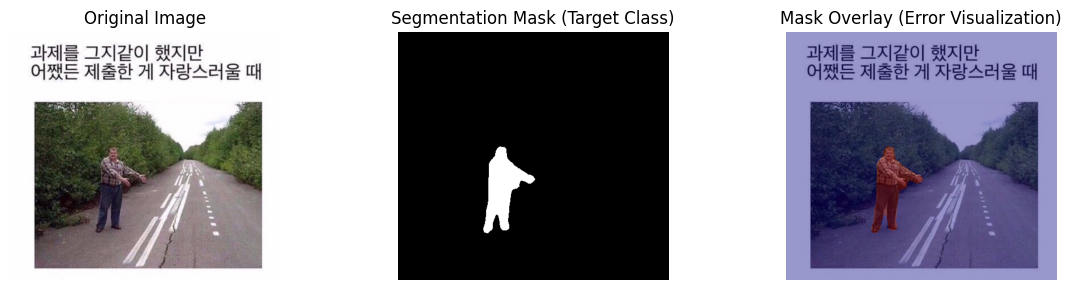

In [11]:
# 함수 테스트

img = load_image(img_path_1)
model = load_model()

seg_map = segment_image(model, img)
person_mask = get_person_mask(seg_map)
overlay = overlay_mask(img, person_mask)

visualize_results(img, person_mask, overlay)

## 1. 인물사진에서 흔히 발생하는 문제

In [12]:
# 이미지 경로
image_infos = [
    {
        "name": "Single Person",
        "path": img_path_1
    },
    {
        "name": "Group Photo (People)",
        "path": img_path_3
    },
    {
        "name": "Animal (Cat)",
        "path": img_path_4
    },
]


 Analyzing: Single Person


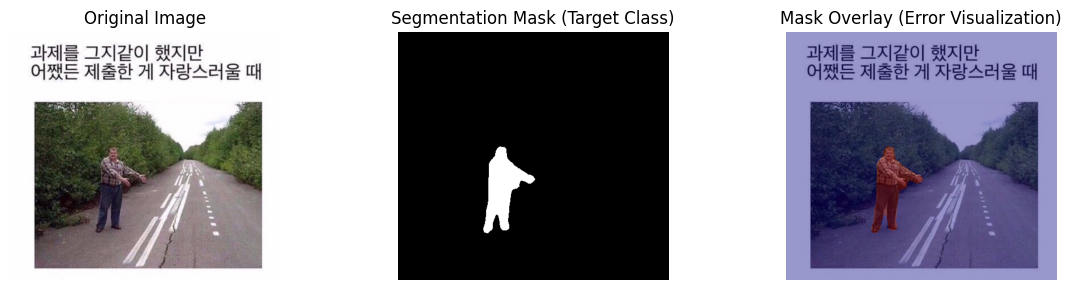


 Analyzing: Group Photo (People)


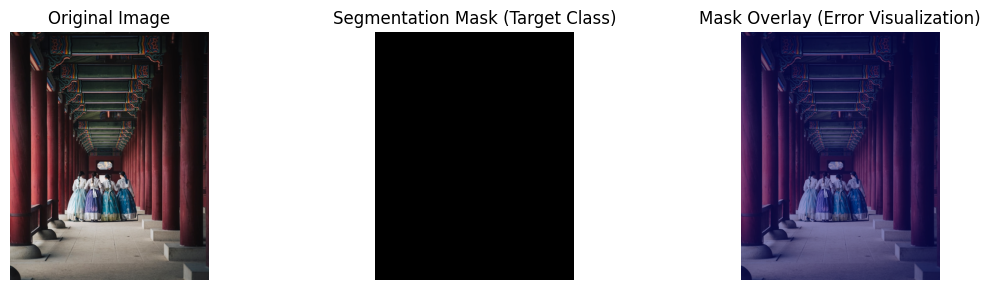


 Analyzing: Animal (Cat)


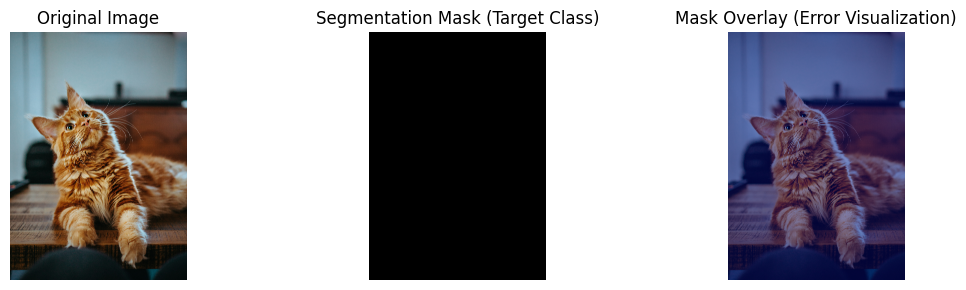

In [13]:
model_1 = load_model()
analyze_multiple_images(image_infos, model_1)

##### 관찰:

**1. 단일 인물 사진 (Single Person)**


*   인물과 배경의 대비가 큰 환경에서는 주요 윤곽은 잘 분리됨
*   하지만 팔과 같은 얇은 구조에서는 경계가 끊기고 단순화되어 세밀한 형태 정보가 손실됨


**2. 단체 인물 사진 (Group Photo)**



*   Segmentation Mask가 완전히 비어 있음 (검정색)
*   화면에서 차지하는 비중이 적고 서로 밀집되어 있어 여러 인물이 하나의 mask로 병합되거나 일부 혹은 모든 인물이 누락됨

**3. 동물 사진 (Cat)**

*   여기에서도 Segmentation Mask가 완전히 비어 있음 (검정색)
*   인간 클래스만을 대상으로 마스크를 생성했기 때문에 동물은 객체로 인식이 되지 않음  

  

  

  
  > 객체 크기, 밀집도, target class 설정이 segmentation 결과에 결정적인 영향을 미친다는 것을 알 수 있다.

## 2. 문제 해결책 제시

### 2-1. 단일 인물 사진

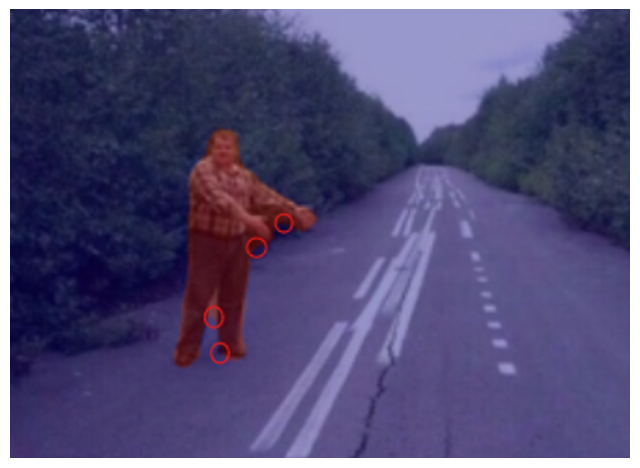

In [14]:
single_person_issues = plt.imread(home_dir + "single-person-issues.png")
plt.figure(figsize=(8, 8))
plt.imshow(single_person_issues)
plt.axis("off")
plt.show()

위 단일 인물 사진은 검출한 인물의 경계가 계단처럼 끊겨보이는 이진 마스크 (binary mask) 의 예시이다.  


원인은 다음과 같다.
- 이진화(Binarization):  
딥러닝 모델의 출력(Softmax/Sigmoid)은 원래 0~1 사이의 연속적인 확률값(Soft Mask)이지만, 최종적으로 0.5 같은 임계값을 기준으로 0 또는 1로 결정하면서 경계가 수치적으로 단절됨  


- 해상도 한계:  
이미지의 픽셀 단위로 영역을 나누기 때문에, 픽셀 크기만큼의 계단 현상(Aliasing)이 발생할 수밖에 없음 (해결 어려움)  




그러므로 솔루션은 **경계를 더 부드럽게 만드는** 다음과 같은 후처리 기법들이다.  

- **Soft Mask** (Soft Segmentation): 0과 1 사이의 확률값을 그대로 유지하여 경계 부분에서 서서히 변화하도록 표현  

- **Gaussian Blur** : 시각적 부드러움이 필요할 때 사용. 이진 마스크에 가우시안 블러(Gaussian Blur)를 적용하여 경계를 뭉개준 뒤 다시 처리  

- **Morphological Smoothing**: 열기(Opening)나 닫기(Closing) 같은 모폴로지 연산을 통해 경계의 노이즈를 제거하고 내부의 작은 구멍을 제거 (`Morphological Transformations`)

- **Anti-aliasing**: 모델 학습 시 경계 부분의 픽셀에 대해 더 정교한 손실 함수를 사용하거나, 더 높은 해상도로 마스크를 생성하는 기법을 사용

### 2-2. 단체 인물 사진

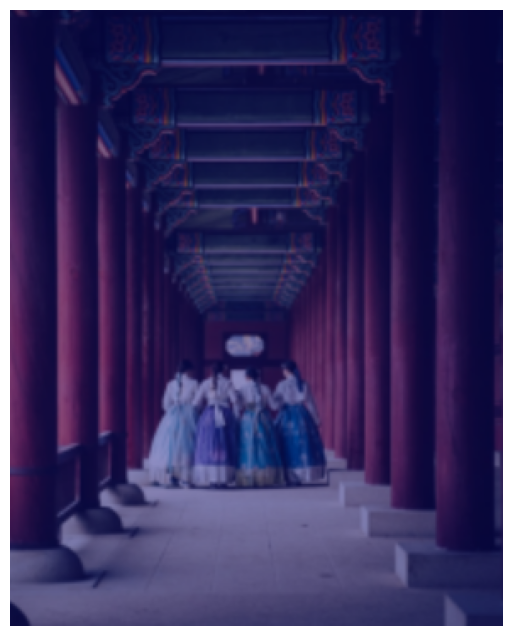

In [15]:
group_people_issues = plt.imread(home_dir + "group-people-issues.png")
plt.figure(figsize=(8, 8))
plt.imshow(group_people_issues)
plt.axis("off")
plt.show()

모델이 단체 인물 탐지에 완전히 실패한 예이다.  
원인은 다음과 같다.
- 인물 크기 문제 (scale):  
DeepLabV3 같은 모델은 중·근거리 인물에 최적화되었는데, 위 사진과 같은 경우에는 프레임 전체에서 인물이 너무 멀리 있거니와 차지하는 비율도 작음
- 다중 인물 + 겹침(occlusion):  
여러 사람이 몰려있어 개별 신체 경계가 뚜렷하지 않음. DeepLabV3는 instance segmentation가 아닌 semantic segmentation을 수행하는 모델로서 사람 덩어리를 하나의 blob으로도 못 잡는 경우 발생함
- 학습 데이터 도메인 차이:  
Pascal VOC의 person 클래스는 일상복, 근거리, 서양 중심 이미지 비율이 높음. 사진에서는 한복, 관광지, 비일상적 구도가 등장해 도메인지 맞지 않을 가능성 높음  

솔루션으로 다음과 같은 방법을 시도해볼 수 있다.
- **ROI 기반 객체 분할**: 사람이 있을 법한 영역만 crop해서 다시 segmentation  

- **Soft failure handling**: 다중 인물이 원거리에서 촬영된 경우 segmentation 모델이 사람 클래스를 검출하지 못할 때를 대비해 mask가 비어 있을 경우 아웃포커싱을 적용하지 않는 fallback 로직을 추가  
- 모델 교체: `SAM (Segment Anything)`, `Mask2Former`, `YOLO + segmentation head` 등 고급 모델로 교체  




  

*단체 인물 사진의 경우 현 시점에서의 솔루션이 너무 뻔하거나 광범위해 해결책 적용 단계에서 제외함 *italicized text*

### 2-3. 동물 사진

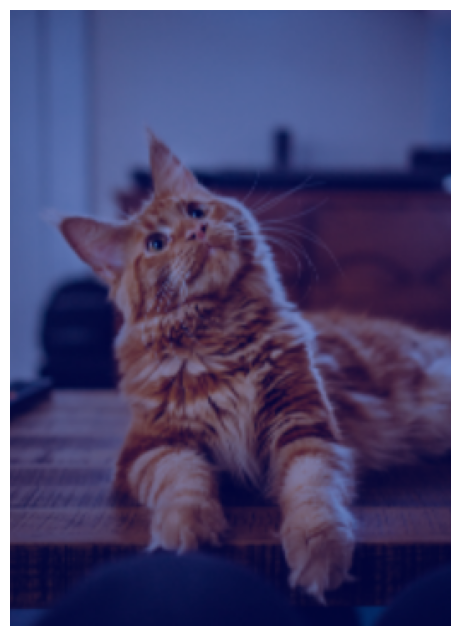

In [16]:
cat_issues = plt.imread(home_dir + "cat-issues.png")
plt.figure(figsize=(8, 8))
plt.imshow(cat_issues)
plt.axis("off")
plt.show()

고양이 탐지에 실패한 대표적인 원인으로 타겟 클래스 설정 오류가 있다.  
현재 파이프라인은 person 클래스만을 대상으로 mask를 생성하므로, cat 이미지에서는 유효한 mask가 생성되지 않았다. 또한 동물의 털 특성상 경계가 불안정해 인물 모드 기반 아웃포커싱에는 한계가 있다.

## 3. 해결책 적용

### 3-1. 아웃포커싱 효과 적용한 인물 사진

In [17]:
# 모델 정의
model_2 = load_model()

In [18]:
# 마스크 생성
# segmentation 수행
seg_map = segment_image(model_2, img)  # image: BGR

# 사람 마스크 생성
person_mask = get_person_mask(seg_map, person_class_id=15)

# 저장
cv2.imwrite(home_dir + "person_mask.png", person_mask)

True

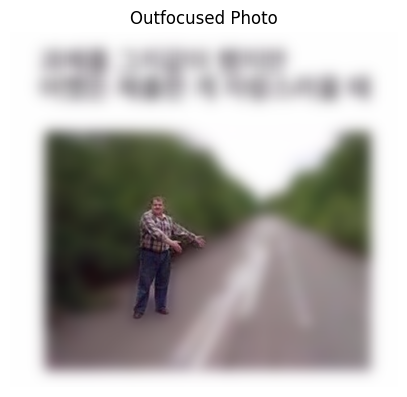

In [19]:
# 1. 이미지 & 마스크 로드
image = cv2.imread(img_path_1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(home_dir + "person_mask.png", cv2.IMREAD_GRAYSCALE) # mask: 사람 = 255, 배경 = 0 이라고 가정

# 2. Morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 3. Gaussian Blur → soft mask
soft_mask = cv2.GaussianBlur(mask_closed, (21, 21), sigmaX=0)
soft_mask = soft_mask.astype(np.float32) / 255.0 # [0, 255] → [0.0, 1.0]
soft_mask = np.expand_dims(soft_mask, axis=2)  # (H, W, 1)

# 4. 배경 블러 처리 (아웃포커싱)
background_blur = cv2.GaussianBlur(image, (51, 51), sigmaX=0)

# 5. Soft mask 기반 합성
foreground = image.astype(np.float32)
background = background_blur.astype(np.float32)

output = foreground * soft_mask + background * (1 - soft_mask)
output = output.astype(np.uint8)

# 6. 결과 출력
output_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(output) # RGB 유지
plt.axis("off")
plt.title("Outfocused Photo")
plt.show()

semantic segmentation 결과는 binary mask 형태로 경계가 날카로워 인물 윤곽이 부자연스럽게 나타나는 문제가 있었다.  

이를 해결하기 위해 morphological closing 연산을 적용하여 마스크 내부의 작은 결손 영역을 보완하고, Gaussian blur를 이용해 soft mask를 생성하였다. 이후 soft mask를 활용해 foreground와 blurred background를 가중합 방식으로 결합함으로써, 인물과 배경의 경계를 자연스럽게 연결한 아웃포커싱 효과를 구현하였다.

### 3-2. 아웃포커싱 효과 적용한 동물 사진

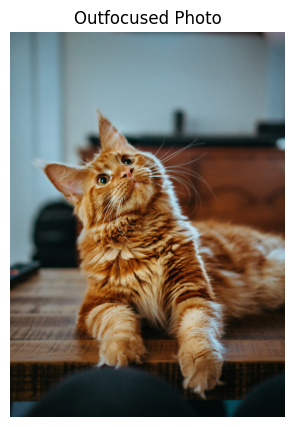

In [20]:
# 1. 이미지 로드
image_cat = cv2.imread(img_path_4)
image_cat = cv2.cvtColor(image_cat, cv2.COLOR_BGR2RGB)

# 2. 세그멘테이션 & 마스크 생성
model_3 = load_model()
seg_map_cat = segment_image(model_3, image_cat)

cat_class_id = 8  # COCO 기준 cat
mask_cat = (seg_map_cat == cat_class_id).astype(np.uint8) * 255

# 3. Morphological closing
kernel_cat = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask_closed_cat = cv2.morphologyEx(mask_cat, cv2.MORPH_CLOSE, kernel_cat)

# 4. Soft mask 생성
soft_mask_cat = cv2.GaussianBlur(mask_closed_cat, (21, 21), sigmaX=0)
soft_mask_cat = soft_mask_cat.astype(np.float32) / 255.0
soft_mask_cat = np.expand_dims(soft_mask_cat, axis=2)  # (H, W, 1)

# 5. 배경 블러 처리 (아웃포커싱)
background_blur_cat = cv2.GaussianBlur(image_cat, (51, 51), sigmaX=0)

# 6. Soft mask 기반 합성
foreground_cat = image_cat.astype(np.float32)
background_cat = background_blur_cat.astype(np.float32)

output_cat = foreground_cat * soft_mask_cat + background_cat * (1 - soft_mask_cat)
output_cat = output_cat.astype(np.uint8)

# 7. 결과 출력
plt.figure(figsize=(5, 5))
plt.imshow(output_cat)
plt.axis("off")
plt.title("Outfocused Photo")
plt.show()

semantic segmentation 모델을 이용해 고양이 객체 분리를 시도했으나, 해당 모델이 사람(person) 클래스를 중심으로 학습되어 고양이를 foreground로 인식하지 못하는 문제가 발생했다.  
이를 해결하기 위해 사람 클래스에 고정된 마스크 생성 방식에서 벗어나 동물 클래스(cat, dog 등)를 명시적으로 지정하거나, 동물 객체에 특화된 segmentation 모델을 사용하는 class-aware 전략이 필요하다.  
위 사진의 경우 클래스를 변경했지만 고양이의 털 색이 배경의 색감과 유사하고, 원본에 이미 어느 정도 배경 블러가 있었기 때문인지 두드러지는 효과는 나타나지 않았다.

### 3-3. 배경 전환 크로마키 사진

원본 나비 이미지 크기: (4599, 2587, 3)
배경(우주) 이미지 크기: (6324, 4041, 3)


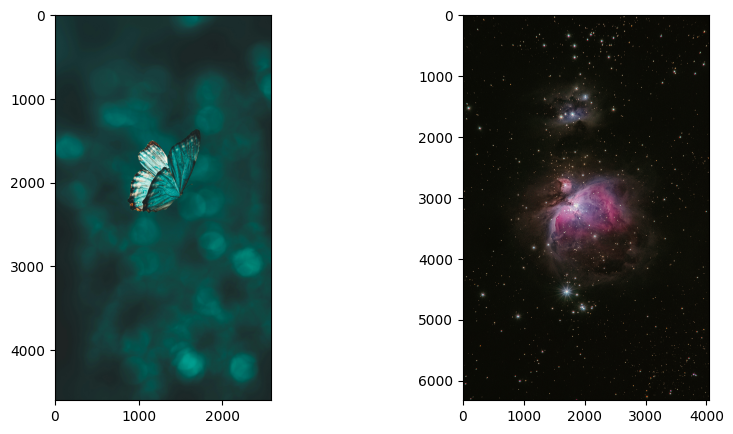

In [21]:
# 1. 이미지 로드
butterfly_img = cv2.imread(img_path_5)
universe_img = cv2.imread(img_path_6)

butterfly_img = cv2.cvtColor(butterfly_img, cv2.COLOR_BGR2RGB)
universe_img = cv2.cvtColor(universe_img, cv2.COLOR_BGR2RGB)

print(f"원본 나비 이미지 크기: {butterfly_img.shape}")
print(f"배경(우주) 이미지 크기: {universe_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(butterfly_img)

plt.subplot(1, 2, 2)
plt.imshow(universe_img)

plt.show()

(4599, 2587, 3) (1581, 889, 1)


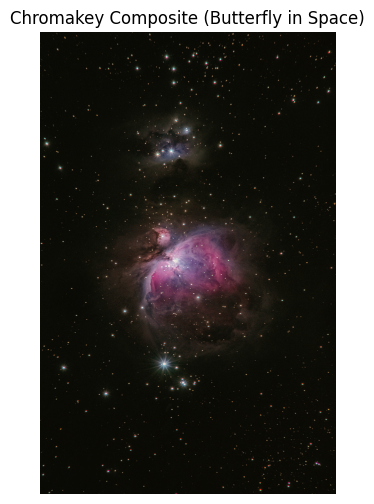

In [22]:
# 2. semantic segmentation을 이용해 나비 마스크 생성
# 초록 배경이 없는 일반 이미지이므로 색 기반 크로마키 대신
# segmentation 결과를 크로마키 마스크로 활용한다.

# segmentation 모델 로드
model_4 = load_model()

# 나비 이미지 segmentation 수행
seg_map_fly = segment_image(model_4, butterfly_img)

# DeepLabV3 (Pascal VOC) 기준 cat 클래스 ID = 8
# 나비는 cat과 유사한 동물 객체로 분류될 가능성을 고려
BUTTERFLY_CLASS_ID = 8

mask_fly = (seg_map_fly == BUTTERFLY_CLASS_ID).astype(np.uint8) * 255


# 3. mask 정제
kernel_fly = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_closed_fly = cv2.morphologyEx(mask_fly, cv2.MORPH_CLOSE, kernel_fly)

# 경계 부드럽게 (soft mask)
soft_mask_fly = cv2.GaussianBlur(mask_closed_fly, (21, 21), 0)

# [0,1] 범위로 정규화
soft_mask_fly = soft_mask_fly.astype(np.float32) / 255.0

# 안전장치: soft_mask_fly가 2차원이면 채널 확장
if soft_mask_fly.ndim == 2:
    soft_mask_fly = soft_mask_fly[:, :, np.newaxis]


# 4. 나비 크기 조절 (배경 크기 기준)
universe_h, universe_w = universe_img.shape[:2]
butterfly_h, butterfly_w = butterfly_img.shape[:2]

target_h = int(universe_h * 0.25)  # 배경 높이의 25%
scale = target_h / butterfly_h

butterfly = cv2.resize(
    butterfly_img,
    None,
    fx=scale,
    fy=scale,
    interpolation=cv2.INTER_AREA
)

# soft mask resize (resize 후 채널 복구 필수)
soft_mask_fly = cv2.resize(
    soft_mask_fly,
    (butterfly.shape[1], butterfly.shape[0])
)

# OpenCV resize로 채널이 사라질 수 있으므로 강제 복구
if soft_mask_fly.ndim == 2:
    soft_mask_fly = soft_mask_fly[:, :, np.newaxis]


# 5. 합성 위치 (배경 중앙 기준)
h, w = butterfly.shape[:2]

y = (universe_h - h) // 2
x = (universe_w - w) // 2

roi = universe_img[y:y+h, x:x+w]


# 6. 합성
print(butterfly_img.shape, soft_mask_fly.shape) # shape 확

composed = (
    butterfly * soft_mask_fly +
    roi * (1 - soft_mask_fly)
).astype(np.uint8)

universe_img[y:y+h, x:x+w] = composed


# 7. 결과 출력
plt.figure(figsize=(6, 6))
plt.imshow(universe_img)
plt.axis("off")
plt.title("Chromakey Composite (Butterfly in Space)")
plt.show()

DeepLabV3 (Pascal VOC) 에서 나비는 아예 학습 대상이 아니었다고 한다. 그래서 마스크가 텅 비어 있어 합성이 안되었다. 이에 따라 색상 기반 크로마키 대신
GrabCut 기반 전경 분리 기법을 적용하여
객체 마스크를 생성하고 합성을 수행하였다.

(4599, 2587, 3) (1581, 889, 1)


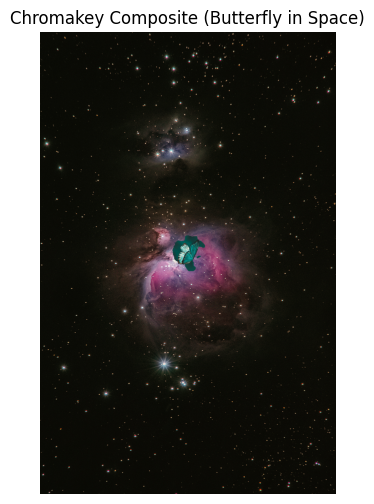

In [23]:
# 2. GrabCut을 이용해 나비 마스크 생성
# 일반 사진(초록 배경 아님)이므로 semantic segmentation 대신
# 전경/배경 분리가 강한 GrabCut 사용

mask_fly = np.zeros(butterfly_img.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# 나비가 이미지 중앙에 있다는 가정
h, w = butterfly_img.shape[:2]
rect = (
    w // 6,
    h // 6,
    w * 2 // 3,
    h * 2 // 3
)

cv2.grabCut(
    butterfly_img,
    mask_fly,
    rect,
    bgdModel,
    fgdModel,
    5,
    cv2.GC_INIT_WITH_RECT
)

# 전경만 255, 나머지는 0
mask_fly = np.where(
    (mask_fly == cv2.GC_FGD) | (mask_fly == cv2.GC_PR_FGD),
    255,
    0
).astype(np.uint8)


# 3. mask 정제
kernel_fly = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_closed_fly = cv2.morphologyEx(mask_fly, cv2.MORPH_CLOSE, kernel_fly)

# 경계 부드럽게 (soft mask)
soft_mask_fly = cv2.GaussianBlur(mask_closed_fly, (21, 21), 0)

# [0,1] 범위로 정규화
soft_mask_fly = soft_mask_fly.astype(np.float32) / 255.0

# 안전장치: soft_mask_fly가 2차원이면 채널 확장
if soft_mask_fly.ndim == 2:
    soft_mask_fly = soft_mask_fly[:, :, np.newaxis]


# 4. 나비 크기 조절 (배경 크기 기준)
universe_h, universe_w = universe_img.shape[:2]
butterfly_h, butterfly_w = butterfly_img.shape[:2]

target_h = int(universe_h * 0.25)  # 배경 높이의 25%
scale = target_h / butterfly_h

butterfly = cv2.resize(
    butterfly_img,
    None,
    fx=scale,
    fy=scale,
    interpolation=cv2.INTER_AREA
)

# soft mask resize (resize 후 채널 복구 필수)
soft_mask_fly = cv2.resize(
    soft_mask_fly,
    (butterfly.shape[1], butterfly.shape[0])
)

# OpenCV resize로 채널이 사라질 수 있으므로 강제 복구
if soft_mask_fly.ndim == 2:
    soft_mask_fly = soft_mask_fly[:, :, np.newaxis]


# 5. 합성 위치 (배경 중앙 기준)
h, w = butterfly.shape[:2]

y = (universe_h - h) // 2
x = (universe_w - w) // 2

roi = universe_img[y:y+h, x:x+w]


# 6. 합성
print(butterfly_img.shape, soft_mask_fly.shape) # shape 확

composed = (
    butterfly * soft_mask_fly +
    roi * (1 - soft_mask_fly)
).astype(np.uint8)

universe_img[y:y+h, x:x+w] = composed


# 7. 결과 출력
plt.figure(figsize=(6, 6))
plt.imshow(universe_img)
plt.axis("off")
plt.title("Chromakey Composite (Butterfly in Space)")
plt.show()

## 정리

- Semantic segmentation 기반 아웃포커싱은 특정 클래스(사람 등)에 최적화되어 있어 클래스 범위를 벗어난 객체에 대해서는 마스크 생성에 한계가 있음을 확인하였다.  
- 본 실험을 통해 이미지 합성 품질은 단순한 블러 처리보다 객체 분리 방식과 마스크 후처리 전략에 크게 의존함을 확인하였다.  
- 이미지 출처:  
  Unsplash

## 회고

- Semantic segmentation 결과를 그대로 활용할 경우 클래스 한계와 마스크 품질 문제로 인해 원하는 합성 효과를 얻기 어렵다는 점이 가장 어려웠다.  
- 마스크와 원본 이미지 간 해상도 및 차원 불일치로 인해 합성 과정에서 반복적으로 에러가 발생하며 디버깅에 많은 시간이 소요되었다.  
- 동물과 같이 털 구조가 복잡한 객체에 대해 어떤 segmentation 모델이나 후처리 전략이 가장 효과적인지에 대한 궁금증이 생겼다.  